In [2]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
import numpy as np, array
from IPython.display import display, Latex

# Fase 1: mappare il problema sul circuito e sugli operatori

#### funzioni ausiliare

In [3]:
def noise_to_theta(noise):
    if not(isinstance(noise, Parameter)):
        # È numerico, verifichiamo che sia nell'intervallo [0,1]
        if (noise<=1 and noise>=0):
            return 2*np.arcsin(np.sqrt(noise))
    else:
        if(not(noise is None)):
            return 2*(noise** 0.5).arcsin()
    raise ValueError("il parametro noise deve appartenere all'intervallo [0,1], o deve essere di tipo Parameter")

def theta_to_noise(theta):
    if not(isinstance(theta, Parameter)):
        # È numerico, convertiamolo
        if(not(theta is None)):
            return np.square(np.sin(theta/2))   
    else: 
        return (theta/2).sin()**2

def reverse_qargs_density_matrix(rho):
    """
    Inverte l'ordine dei qubit (little-endian vs big-endian) in una matrice densità.

    Questo è utile quando si vuole cambiare l'ordinamento dei qubit nel prodotto tensore,
    ad esempio passando da |q0⟩ ⊗ |q1⟩ a |q1⟩ ⊗ |q0⟩.

    Parametri:
        rho (DensityMatrix): matrice densità di input (multi-qubit)

    Restituisce:
        DensityMatrix: matrice densità con ordine dei qubit invertito
    """
    return DensityMatrix((rho.to_operator().reverse_qargs().to_matrix()))

## Circuito convenzione classica

### Definisco il canale Amplitude Damping

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

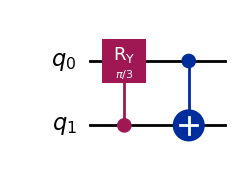

In [4]:
def amplitude_damping_gate(_noise=None):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente) nella convenzione classica.

    Parametri:
        _noise (float or Parameter): valore tra 0 e 1 che viene convertito in angolo per la rotazione Ry
            ! se non viene istanziato allora di default è Parameter('η')

    Restituisce:
        Gate: un gate "AmpDamp" personalizzato da applicare a 2 qubit
    """
    if _noise is None : _noise = Parameter('η')
    # converto il parametro del rumore in theta
    theta = noise_to_theta(_noise)

    # Crea un circuito con 2 qubit: qubit 0 = S_1, qubit 1 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model")
    
    # Applicazione delle porte
    # Applica una porta controllata-RY(θ)
    qc.cry(theta ,1 ,0 )     # controllo su qubit 0 (S1), target qubit 1 (E1) (secondo la convenzione classica, qiskit inverte i controlli e i target)
    qc.cx(0, 1)              # CNOT: controllo E_1 (qubit 1), target S_1 (qubit 0)

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp")
    
    return gate

# circuito esempio con questo canale
example = QuantumCircuit(2)

# applico il gate che simula il canale amplitude damping
example.append(amplitude_damping_gate(theta_to_noise(np.pi/3)), [0 ,1])

# example.append(amplitude_damping_gate(), [0 ,1])

display(Latex(r"Matrice del circuito (parametro = $\frac{\pi}{3}$)"))

# permette di trasformare il circuito nella sua rappresentazione di operatore
display(Operator.from_circuit(example).draw("latex")) 

# mostra il circuito decomposto
display(example.decompose().draw("mpl"))



### Definisco lo stato iniziale del circuito nella forma di matrice densità parametrizzata

In [5]:

def initial_mixed_state_real_density_matrix(_alpha):
    """
    Crea una matrice densità a 2 qubit come stato iniziale, in cui:
    - Il qubit di sistema (qubit 0 S_1) è in uno stato misto reale parametrizzato da alpha:
        ρ_sis = (1 - α)|0⟩⟨0| + α|1⟩⟨1|
    - Il qubit di ambiente (qubit 1 E_1) è inizializzato nello stato puro |0⟩⟨0|
    - L'output è il prodotto tensore ρ_sis ⊗ ρ_env, rappresentato come oggetto DensityMatrix

    Parametri:
        _alpha (float): parametro di mescolanza ∈ [0, 1]; 

    Restituisce:
        DensityMatrix: stato iniziale a 2 qubit (sistema + ambiente)
    """
    # Parametro di mescolanza
    alpha = _alpha

    #creo una matrice in forma array[array[,...],...]
    rho_sis_matrix = [[1 - alpha, 0],
                [0, alpha]]
    
    # Creo lo stato misto da rho_0_matrix per qubit 0
    rho_sis = DensityMatrix(rho_sis_matrix)

    # creo lo stao del qubit 1 (ambiente) in |0>
    rho_env = DensityMatrix.from_label('0')

    # Stato iniziale totale a 2 qubit
    rho_in = rho_sis.tensor(rho_env)

    return rho_in

# eseguo uno stato misto di esempio sul circuito di esempio generato prima
alpha = 0.3

# genero lo stato iniziale con il parametro 0.3
rho_in = initial_mixed_state_real_density_matrix(alpha)

# mostro lo stato iniziare dell'intero sistema
display(rho_in.draw("latex"))

# faccio evolvere il sistema secondo il canale amplitude damping (applicazione postulato 2)
rho_final = rho_in.evolve(example)

# mostro lo stato finale dell'intero sistema  
display(partial_trace(rho_final,[]).draw("latex"))
# mostro lo stato finale del sottosistema S_1
display(partial_trace(rho_final,[0]).draw("latex"))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Definisco il canale per calcolare l'error rate

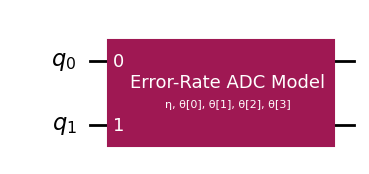

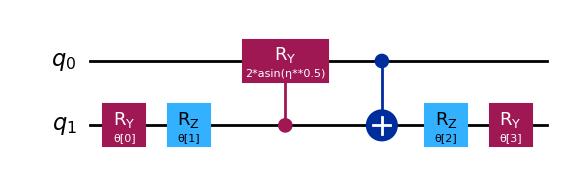

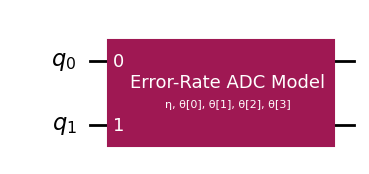

forma matriciale dell'operatore dell'intero circuito


<IPython.core.display.Latex object>

forma matriciale e rappresentazione stato finale nella sfera di bloch


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

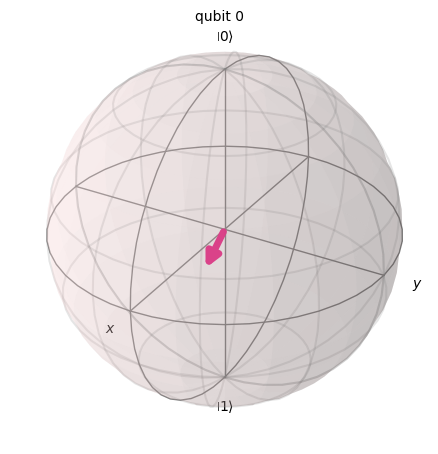

Probabilità di misura in |0⟩: 0.5224
Probabilità di misura in |1⟩: 0.4776


In [6]:

def build_parametrized_eradc(thetas=None,noise=None):
    """
    Costruisce un gate quantistico parametrizzato a 2 qubit che modella
    un canale di amplitude damping con pre- e post-rotazioni controllate da parametri.

    Parametri:
        thetas (ParameterVector, opzionale): vettore di 4 parametri simbolici
            che definiscono le rotazioni RY e RZ applicate prima e dopo il canale.
            Se non fornito, viene generato automaticamente come [θ₀, θ₁, θ₂, θ₃].

        noise (Parameter, opzionale): parametro simbolico che rappresenta il
            livello di rumore del canale di damping. Se non fornito, viene
            inizializzato come η.

    Restituisce:
        Gate: un gate custom che implementa il modello parametrico di un
              canale di amplitude damping con rotazioni controllate nella convenzione classica.
    """

    # Se i parametri non sono stati forniti, crea simboli di default
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter('η')

    # Controlla che siano forniti esattamente 4 parametri angolari
    if len(thetas) != 4:
        raise ValueError("Il ParameterVector deve contenere esattamente 4 parametri.")
    
     # Crea un circuito su 2 qubit:
    # - qubit 0 = ambiente
    # - qubit 1 = sistema (qubit target del canale)
    qc = QuantumCircuit(2)

    qc.ry(thetas[0], 1)                      # RY su qubit sis
    qc.rz(thetas[1], 1)                      # RZ su qubit sis

    qc.append(amplitude_damping_gate(noise), [0, 1]) # Amplitude damping su [0,1]

    qc.rz(thetas[2], 1)                      # RZ su qubit sis
    qc.ry(thetas[3], 1)                      # RY su qubit sis
    
    # Converte in un Custom Gate
    gate = qc.to_gate(label="Error-Rate ADC Model")
    
    # Ritorna il gate
    return gate

# creo il circuito
ERADC = QuantumCircuit(2)

# aggiungo il gate che simula il canale amplitude damping
ERADC.append(build_parametrized_eradc(), [0,1])

# creo un dizionario dove per ogni parametro "nome_param": assegna_value
param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    "η"  : theta_to_noise(np.pi/3)
}
# print(ERADC.parameters)

#mostra il circuito
display(ERADC.draw("mpl"))

# mostra il circuito decomposto
display(ERADC.decompose().decompose("AmpDamp").draw("mpl")) 

# print(ERADC.parameters) #permette di mostrare tutti i parametri non definiti

# test circuito matrice
# assegna al circuito tutti i parametri definiti nel dizionario
bound_ERADC = ERADC.assign_parameters(param_values)

# mostra il circuito
display(ERADC.draw("mpl"))

print("forma matriciale dell'operatore dell'intero circuito")
# mostra l'operatore in forma matriciale che agisce sul canale
display(Operator.from_circuit(bound_ERADC).draw("latex"))

rho_out = rho_in.evolve(bound_ERADC)
# display(rho_out.draw("bloch"))
print("forma matriciale e rappresentazione stato finale nella sfera di bloch")
display(rho_out.draw("latex"))
display(partial_trace(rho_out,[0]).draw("latex"))
display(partial_trace(rho_out,[0]).draw("bloch"))

# Il metodo .probabilities() calcola le probabilità di misura in base computazionale (|0⟩, |1⟩, ..., |2ⁿ - 1⟩)
# per lo stato quantistico rappresentato dalla matrice densità o dallo statevector.
# Restituisce un array di float, in cui ciascun elemento corrisponde alla probabilità
# di osservare uno specifico stato base nella misura.
print(f"Probabilità di misura in |0⟩: {partial_trace(rho_out,[0]).probabilities()[0]:.4f}")
print(f"Probabilità di misura in |1⟩: {partial_trace(rho_out,[0]).probabilities()[1]:.4f}")

## Convenzione Qiskit

### Definisco il canale Amplitude Damping

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

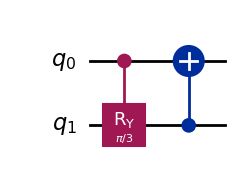

In [7]:
def amplitude_damping_gate_qi(_noise=None):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente) nella convezione di qiskit.

    Parametri:
        _noise (float or Parameter): valore tra 0 e 1 che viene convertito in angolo per la rotazione Ry
            ! se non viene istanziato allora di default è Parameter('η')

    Restituisce:
        Gate: un gate "AmpDamp qi" personalizzato da applicare a 2 qubit
    """
    # Crea un circuito con 2 qubit: qubit 1 = S_1, qubit 0 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model Qi")

    # basta invertire il collegamento del canale definito precedentemente
    qc.append(amplitude_damping_gate(_noise),[1,0])

    qc = qc.decompose()

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp qi")
    
    return gate

# circuito esempio con questo canale
example_q = QuantumCircuit(2)

# applico il gate che simula il canale amplitude damping
example_q.append(amplitude_damping_gate_qi(theta_to_noise(np.pi/3)), [0 ,1])
# example_q.append(amplitude_damping_gate_qi(), [0 ,1])

display(Latex(r"Matrice del circuito (parametro = $\frac{\pi}{3}$)"))

# permette di trasformare il circuito nella sua rappresentazione di operatore
display(Operator.from_circuit(example_q).draw("latex")) 

# mostra il circuito decomposto
display(example_q.decompose().draw("mpl"))

### Definisco lo stato iniziale del circuito nella forma di matrice densità parametrizzata

In [8]:
# eseguo uno stato misto di esempio sul circuito di esempio generato prima
alpha = 0.3

# genero lo stato iniziale con il parametro 0.3 (invertito per la convenzione qiskit, il qubit 1 è S_1, il qubit 0 è E_1)
rho_in_q = reverse_qargs_density_matrix(initial_mixed_state_real_density_matrix(alpha))

# mostro lo stato iniziare dell'intero sistema
display(rho_in_q.draw("latex"))

# faccio evolvere il sistema secondo il canale amplitude damping (applicazione postulato 2)
rho_final_q = rho_in_q.evolve(example_q)

# mostro lo stato finale dell'intero sistema  
display(partial_trace(rho_final_q,[]).draw("latex"))
# mostro lo stato finale del sottosistema S_1
display(partial_trace(rho_final_q,[1]).draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Definisco il canale per calcolare l'error rate

 forma matriciale dell'operatore dell'intero circuito


<IPython.core.display.Latex object>

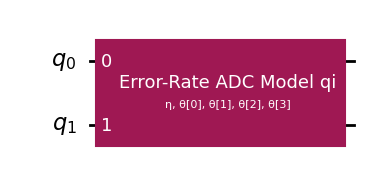

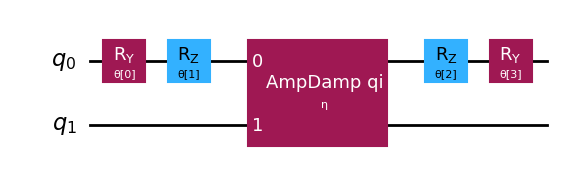

forma matriciale e rappresentazione stato finale nella sfera di bloch


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

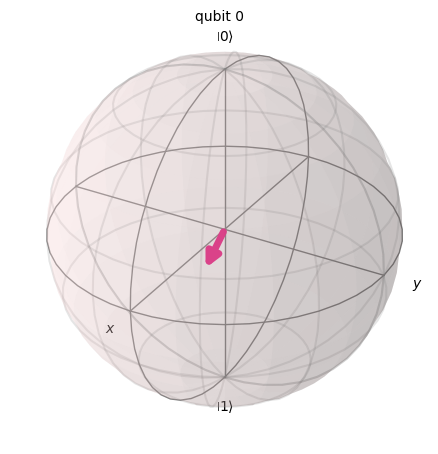

Probabilità di misura in |0⟩: 0.5224
Probabilità di misura in |1⟩: 0.4776


In [9]:

def build_parametrized_eradc_qi(thetas=None,noise=None):
    """
    Costruisce un gate quantistico parametrico a 2 qubit che modella un canale di 
    amplitude damping, con rotazioni personalizzate prima e dopo il canale, secondo 
    la convenzione standard Qiskit (qubit 0 = sistema, qubit 1 = ambiente/ancilla).

    Parametri:
        thetas (ParameterVector): vettore di 4 parametri simbolici (θ₀, θ₁, θ₂, θ₃)
            che controllano le rotazioni applicate al qubit del sistema:
              - θ₀, θ₁: rotazioni iniziali RY e RZ
              - θ₂, θ₃: rotazioni finali RZ e RY

        noise (Parameter): parametro simbolico (es. θa) che regola il livello di damping 
            nel canale amplitude damping (η ∈ [0,1])

    Restituisce:
        Gate: un gate custom riutilizzabile che implementa l'intero blocco
              "rotazioni + canale ADC + rotazioni", pronto per essere inserito in un circuito.
    """
    # Controllo che siano esattamente 4 parametri (due pre-rotazioni, due post-rotazioni)
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter('η')

    # verifico che il vettore di parametri thetas coincide con quelli del circuito altrimenti solleva un eccezione
    if len(thetas) != 4:
        raise ValueError("Il ParameterVector deve contenere esattamente 4 parametri.")
    
    # Crea un circuito su 2 qubit:
    # - qubit 0 = sistema (su cui agiscono le rotazioni)
    # - qubit 1 = ambiente (serve a implementare il canale ADC come interazione)
    qc = QuantumCircuit(2)

    qc.ry(thetas[0], 0)                      # RY su qubit sis
    qc.rz(thetas[1], 0)                      # RZ su qubit sis

    qc.append(amplitude_damping_gate_qi(noise), [0, 1]) # Amplitude damping su [0,1]

    qc.rz(thetas[2], 0)                      # RZ su qubit sis
    qc.ry(thetas[3], 0)                      # RY su qubit sis
    
    # Converte in un Custom Gate
    gate = qc.to_gate(label="Error-Rate ADC Model qi")
    
    # Ritorna il gate
    return gate

# creo il circuito
ERADC_q = QuantumCircuit(2)

# aggiungo il gate che simula il canale amplitude damping
ERADC_q.append(build_parametrized_eradc_qi(), [0,1])

# creo un dizionario dove per ogni parametro "nome_param": assegna_value
param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    "η"  : theta_to_noise(np.pi/3)
}
# print(ERADC.parameters)

# assegna al circuito tutti i parametri definiti nel dizionario
bound_ERADC_q = ERADC_q.assign_parameters(param_values)

print(" forma matriciale dell'operatore dell'intero circuito")

# mostra l'operatore in forma matriciale che agisce sul canale
display(Operator.from_circuit(bound_ERADC_q).draw("latex"))

#mostra il circuito
display(ERADC_q.draw("mpl"))

# mostra il circuito decomposto
display(ERADC_q.decompose().decompose("AmpDamp").draw("mpl")) 

# print(ERADC.parameters) #permette di mostrare tutti i parametri non definiti

# test circuito matrice
rho_out_q = rho_in_q.evolve(bound_ERADC_q)
# display(rho_out.draw("bloch"))
print("forma matriciale e rappresentazione stato finale nella sfera di bloch")
display(rho_out_q.draw("latex"))
display(partial_trace(rho_out_q,[1]).draw("latex"))
display(partial_trace(rho_out_q,[1]).draw("bloch"))

# Il metodo .probabilities() calcola le probabilità di misura in base computazionale (|0⟩, |1⟩, ..., |2ⁿ - 1⟩)
# per lo stato quantistico rappresentato dalla matrice densità o dallo statevector.
# Restituisce un array di float, in cui ciascun elemento corrisponde alla probabilità
# di osservare uno specifico stato base nella misura.
print(f"Probabilità di misura in |0⟩: {partial_trace(rho_out_q,[1]).probabilities()[0]:.4f}")
print(f"Probabilità di misura in |1⟩: {partial_trace(rho_out_q,[1]).probabilities()[1]:.4f}")


## Check dei circuiti creati

### Check Amplitude Damping

In [ ]:
eta = [round(i * 0.1, 1) for i in range(11)]

alpha = [round(i * 0.1, 1) for i in range(11)]

for e in eta:
    for a in alpha:
        kraus_op_adc_0 = [[1, 0],[0,np.sqrt(1-e)]]
        kraus_op_adc_0_dag = Operator(kraus_op_adc_0).adjoint().data

        kraus_op_adc_1 = [[0, np.sqrt(e)],[0,0]]
        kraus_op_adc_1_dag = Operator(kraus_op_adc_1).adjoint().data

        rho_in_total = initial_mixed_state_real_density_matrix(a)
        rho_in_sis = partial_trace(rho_in_total, [0]).to_operator()
        # calcolo esplicitamente la matrice densità di output dal circuito teorico
        rho_out_teorical = DensityMatrix(kraus_op_adc_0 @ rho_in_sis.data @ kraus_op_adc_0_dag + kraus_op_adc_1 @ rho_in_sis.data @ kraus_op_adc_1_dag)
        rho_out_teorical.draw("latex")
        
        qc0 = QuantumCircuit(2, name ="test")
        qc0.append(amplitude_damping_gate(e),[0,1])

        qc1 = QuantumCircuit(2, name ="test")
        qc1.append(amplitude_damping_gate_qi(e), [0,1])

        # calcolo faccio evolvere i circuiti e ottengo la matrice densità di output dai due circuiti e la confronto su un insieme di dati in ingresso
        rho_out_total_cir  = rho_in_total.evolve(qc0)
        rho_out_cir = partial_trace(rho_out_total_cir, [0])

        rho_out_total_cir_q  = reverse_qargs_density_matrix(rho_in_total).evolve(qc1)
        rho_out_cir_q = partial_trace(rho_out_total_cir_q, [1])

        # Calcola la distanza di Frobenius tra le due matrici
        distance = np.linalg.norm(rho_out_teorical.data - rho_out_cir.data, ord='fro')
        distance1 = np.linalg.norm(rho_out_teorical.data - rho_out_cir_q.data, ord='fro')
        # eseguo il prodotto interno tra operatori
        #inner_prod0 = np.trace((rho_out_teorical.to_operator().adjoint().dot(rho_out_cir.to_operator())).to_matrix())
        if not((rho_out_cir.to_operator().equiv(rho_out_teorical.to_operator())) and (rho_out_cir_q.to_operator().equiv(rho_out_teorical.to_operator()))):  # tolleranza numerica
            print(f"Rho diversi per eta = {e}, alpha = {a}")
            print("matrice densita circuito convenzione classica")
            display(rho_out_cir.draw("latex"))
            print("matrice densita circuito convenzione qiskit")
            display(rho_out_cir_q.draw("latex"))
            print("matrice densita circuito calcolato teoricamente")
            display(rho_out_teorical.draw("latex"))
            print(f"Distanza dei due stati teorico e conv. clas.: {distance:.6f}, teorico e conv. qiskit: {distance1:.6f}")
            # Esci da entrambi i loop
            break  # esce dal ciclo interno
        else:
            print(f"distanza = {distance}, distanza1 = {distance1}")
            continue  # eseguito solo se il ciclo interno NON ha fatto break
    #break        # eseguito se il ciclo interno ha fatto break


distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza = 0.0, distanza1 = 0.0
distanza

# Fase 2 evoluzione del circuito e misura con lo stato iniziale misto definito

## Extra inizializzazione stato parametrico con ancilla

### Ancilla per ricreare lo stato misto sia convenzione classica che Qiskit

Matrice densità ridotta (target qubit):


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

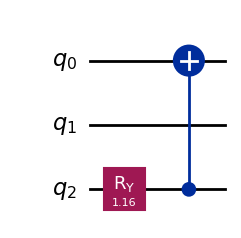

In [10]:
def getAncillaParametrized(_alpha=None):
    """
    Costruisce un gate quantistico che inizializza un qubit target (qubit 0)
    in uno stato misto con popolazioni [1 - α, α] tramite entanglement con un’ancilla (qubit 2).

    Parametri:
        _alpha (float o Parameter): probabilità di osservare il qubit target nello stato |1⟩
                                     dopo tracciatura dell’ancilla.
                                     Può essere un valore numerico o un parametro simbolico.

    Restituisce:
        Gate: un gate custom che può essere inserito in un circuito per inizializzare
              lo stato del qubit target in modo controllato.
        !! nel cubit 0,1 abbiamo uno stato iniziale del tipo q1 ⊗ rho_sis,
        !! mentre nel qubit 1,2 abbiamo uno stato del tipo rho_sis ⊗ q1.
    """

    # Calcola simbolicamente o numericamente l'angolo theta = 2arcsin(sqrt(α))
    # In modo che lo stato preparato sia: (1 - α)|0⟩ + (α)|1⟩
    if _alpha is None:
        _alpha = Parameter("α") 
    if isinstance(_alpha, Parameter):
        theta = 2*(_alpha ** 0.5).arcsin()
    else:
        theta = 2*np.arcsin(np.sqrt(_alpha))

    An = QuantumCircuit(3, name= "Ancilla")
    An.ry(theta, 2)  # crea sovrapposizione su qubit 0
    An.cx(2, 0)  # entanglement con qubit 2

    # crea due stati uno q1 = rho_env ⊗ q0 = rho_sis (conv. qiskit),
    # mentre l'altro è q2 = rho_sis ⊗ q1 = rho_env (conv. classica).

    # converte in un gate
    gate = An.to_gate(label="AncInitilizeState")

    return gate

# alpha = Parameter('α')
alpha = 0.3
example = QuantumCircuit(3)
example.append(getAncillaParametrized(alpha), [0,1,2])

print("Matrice densità ridotta (target qubit):")
display(partial_trace(DensityMatrix.from_label("000").evolve(example), [0]).draw("latex"))
display(partial_trace(DensityMatrix.from_label("000").evolve(example), [2]).draw("latex"))
display(example.decompose().draw("mpl"))



### Ancilla usato sul circuito con convenzione classica

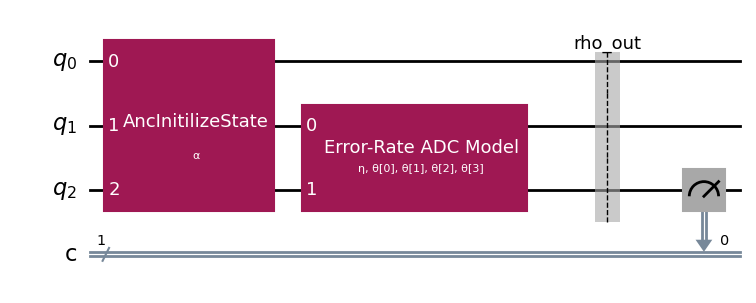

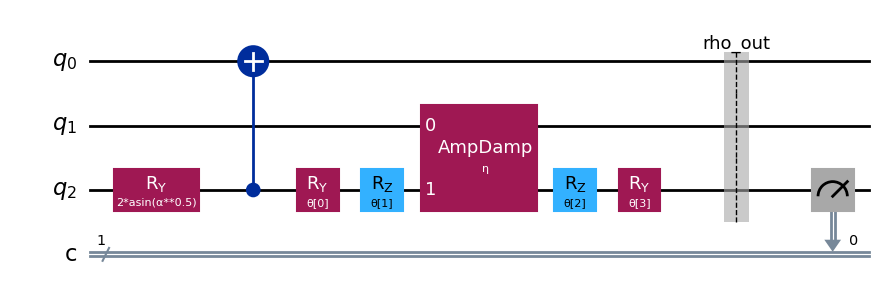

In [11]:
def circuitERADC_with_Ancilla_parametrized_measure(alpha=None,thetas=None,noise=None):
    """
    Costruisce un circuito quantistico a 3 qubit che simula un canale di amplitude damping
    (ERADC: Error-Rate Amplitude Damping Channel) usando un approccio ancilla-based.

    Il circuito applica:
      - una preparazione di stato misto tramite entanglement con un'ancilla,
      - un blocco parametrico che rappresenta il canale di damping,
      - una misura sul qubit del sistema.

    Parametri:
        alpha (float o Parameter, opzionale):
            Parametro di mescolanza iniziale per generare uno stato misto su qubit 1,
            tramite un'operazione su qubit 2 (ancilla). Se non fornito, è simbolico (α).

        thetas (ParameterVector, opzionale):
            Vettore di 4 parametri (θ₀, θ₁, θ₂, θ₃) per rotazioni RY/RZ pre- e post-damping.
            Se non fornito, vengono creati automaticamente come simbolici.

        noise (float o Parameter, opzionale):
            Parametro di damping per il canale ADC. Se non fornito, è simbolico (η).

    Restituisce:
        QuantumCircuit:
            Il circuito quantistico a 3 qubit con preparazione dello stato, evoluzione
            tramite il canale parametrico e misura sul sistema.
    """

    # Inizializzazione parametri simbolici se non forniti
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter("η")
    if alpha is None:
        alpha = Parameter("α")

    # Crea circuito con 3 qubit e 1 bit classico
    # qubit 2: ancilla per creare lo stato misto
    # qubit 1: ambiente (per amplitude damping)
    # qubit 0: sistema (target)
    ERADC_mea = QuantumCircuit(3, 1, name="ERADC with Ancilla and measure")

    # Inizializzazione dello stato misto tramite circuito ancilla (entanglement tra qubit 2 e 0)
    ERADC_mea.append(getAncillaParametrized(alpha), [0, 1, 2])

    # Applica il canale di damping parametrico tra sistema (1) e ambiente (2)
    ERADC_mea.append(build_parametrized_eradc(thetas, noise), [1, 2])

    # Salva la matrice densità completa prima della misura (per ispezione)
    ERADC_mea.save_density_matrix(label="rho_out")

    # Misura il qubit del sistema (qubit 2), risultato registrato nel bit classico 0
    ERADC_mea.measure(2, 0)

    return ERADC_mea

example = circuitERADC_with_Ancilla_parametrized_measure()

display(example.draw("mpl"))
display(example.decompose().draw("mpl"))


### Ancilla usato sul circuito con convenzione qiskit

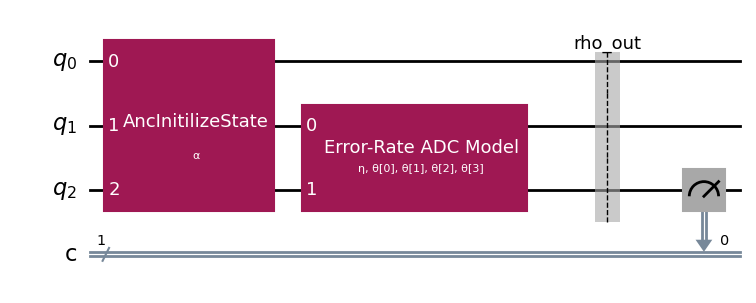

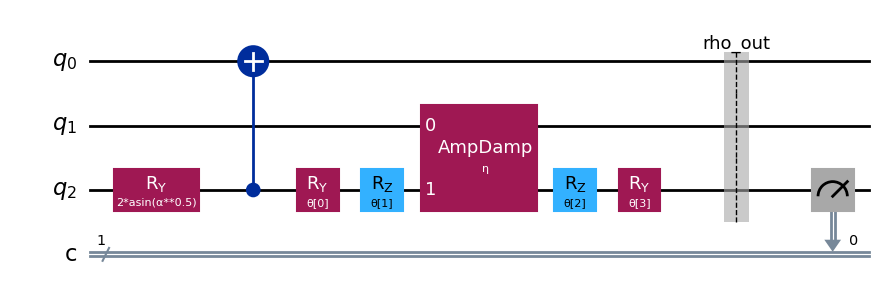

In [12]:
def circuitERADC_with_Ancilla_parametrized_measure_qi(alpha=None,thetas=None,noise=None):
    """
    Costruisce un circuito quantistico a 3 qubit che simula un canale di amplitude damping
    (ERADC: Error-Rate Amplitude Damping Channel) usando un approccio ancilla-based.

    Il circuito applica:
      - una preparazione di stato misto tramite entanglement con un'ancilla,
      - un blocco parametrico che rappresenta il canale di damping,
      - una misura sul qubit del sistema.

    Parametri:
        alpha (float o Parameter, opzionale):
            Parametro di mescolanza iniziale per generare uno stato misto su qubit 1,
            tramite un'operazione su qubit 2 (ancilla). Se non fornito, è simbolico (α).

        thetas (ParameterVector, opzionale):
            Vettore di 4 parametri (θ₀, θ₁, θ₂, θ₃) per rotazioni RY/RZ pre- e post-damping.
            Se non fornito, vengono creati automaticamente come simbolici.

        noise (float o Parameter, opzionale):
            Parametro di damping per il canale ADC. Se non fornito, è simbolico (η).

    Restituisce:
        QuantumCircuit:
            Il circuito quantistico a 3 qubit con preparazione dello stato, evoluzione
            tramite il canale parametrico e misura sul sistema.
    """

    # Inizializzazione parametri simbolici se non forniti
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter("η")
    if alpha is None:
        alpha = Parameter("α")

    # Crea circuito con 3 qubit e 1 bit classico
    # qubit 0: ancilla per creare lo stato misto
    # qubit 1: ambiente (per amplitude damping)
    # qubit 2: sistema (target)
    ERADC_mea = QuantumCircuit(3, 1, name="ERADC with Ancilla and measure")

    # Inizializzazione dello stato misto tramite circuito ancilla (entanglement tra qubit 2 e 0)
    ERADC_mea.append(getAncillaParametrized(alpha), [0, 1, 2])

    # Applica il canale di damping parametrico tra sistema (1) e ambiente (2)
    ERADC_mea.append(build_parametrized_eradc_qi(thetas, noise), [0, 1])

    # Salva la matrice densità completa prima della misura (per ispezione)
    ERADC_mea.save_density_matrix(label="rho_out")

    # Misura il qubit del sistema (qubit 2), risultato registrato nel bit classico 0
    ERADC_mea.measure(0, 0)

    return ERADC_mea

example = circuitERADC_with_Ancilla_parametrized_measure()

display(example.draw("mpl"))
display(example.decompose().draw("mpl"))

## Simulazioni

### Aggiungo al circuito la misura e il bit di registo delle misurazioni (uso il circuito con convenzione classica)

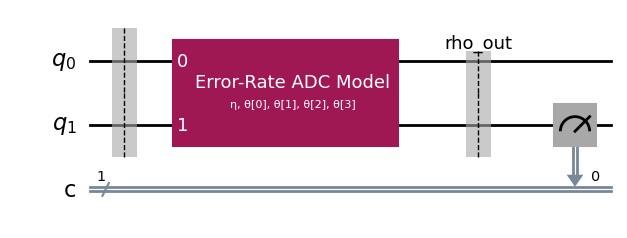

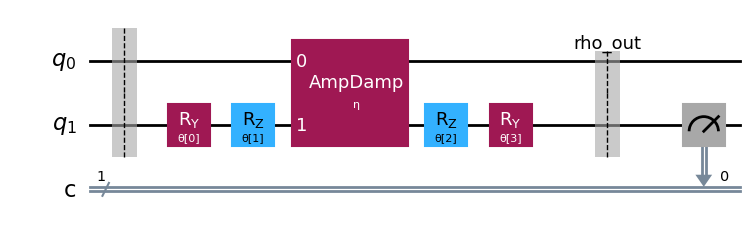

In [13]:
def circuitERADC_parametrized_measure(alpha,thetas=None,noise=None):
    """
    Costruisce un circuito quantistico a 2 qubit per simulare un modello
    di amplitude damping (ERADC), partendo da uno stato misto iniziale,
    e con parametri simbolici per le rotazioni e il rumore.

    Parametri:
        alpha (float): parametro di mescolanza per lo stato iniziale del sistema
                ρ_sis = (1 - α)|0⟩⟨0| + α|1⟩⟨1| ! Deve essere istanziato non puo essere parametrico

        thetas (ParameterVector): vettore di 4 parametri per le rotazioni del sistema
        noise (Parameter): parametro simbolico per l’intensità del rumore (amplitude damping)

    Restituisce:
        QuantumCircuit: circuito parametrico con stato iniziale misto e misura
    """

    # Controllo che siano esattamente 4 parametri (due pre-rotazioni, due post-rotazioni)
    if thetas is None:
        thetas = ParameterVector("θ", 4)
    if noise is None:
        noise = Parameter('η')

    # Crea lo stato iniziale a 2 qubit (sistema + ambiente), con il sistema in stato misto
    rho_in = initial_mixed_state_real_density_matrix(alpha)
    
    # Crea un circuito quantistico con 2 qubit e 1 bit classico per la misura
    ERADC_mea = QuantumCircuit(2, 1, name= "ERADC with measure")

    # Imposta lo stato iniziale del circuito come matrice densità (solo su AerSimulator)
    ERADC_mea.set_density_matrix(rho_in)
    
    # Applica il blocco ERADC parametrico sul sistema (qubit 0) e ambiente (qubit 1)
    ERADC_mea.append(build_parametrized_eradc(thetas,noise), [0,1])

    # Salva la matrice densità finale (dopo l’evoluzione e prima della misura)
    ERADC_mea.save_density_matrix(label = "rho_out")

    # Misura il qubit sis
    ERADC_mea.measure(1,0)

    return ERADC_mea

alpha = 0.3

example = circuitERADC_parametrized_measure(alpha)

display(example.draw("mpl"))
display(example.decompose().draw("mpl"))


In [14]:
def aerSimulationOfERADC(alpha,params,_shots):
    """
    Esegue una simulazione del circuito ERADC (Error-Rate Amplitude Damping Channel)
    utilizzando AerSimulator con il metodo della matrice densità (density matrix simulation).

    Parametri:
        alpha (float):
            Parametro di mescolanza dello stato iniziale del sistema.
            Rappresenta la probabilità di inizializzare il sistema in |1⟩.
            Viene usato per generare lo stato iniziale come matrice densità mista.

        params (dict):
            Dizionario che associa i parametri simbolici del circuito (ad esempio "θ[0]", "η")
            ai rispettivi valori numerici da utilizzare per la simulazione.
            Deve contenere:
                - "θ[0]" ... "θ[3]": angoli per le rotazioni RY/RZ prima e dopo il canale ADC
                - "η": livello di rumore (parametro del canale di amplitude damping)

        _shots (int):
            Numero di esecuzioni (ripetizioni) da effettuare durante la simulazione. Serve
            per ottenere statistiche sulle misurazioni del circuito, anche se non sono necessarie
            per simulazioni puramente deterministiche con la matrice densità.

    Restituisce:
        result (qiskit.result.Result):
            Oggetto contenente i risultati della simulazione.
            Include:
                - lo stato finale del sistema ("rho_out") come matrice densità
                - le distribuzioni di probabilità di misura (get_counts, se misure sono presenti)
    """  
    # Inizializza il simulatore con supporto per la simulazione a matrice densità
    sim = AerSimulator(method='density_matrix')

    # Costruisce il circuito parametrico con stato iniziale definito da 'alpha'
    qc = circuitERADC_parametrized_measure(alpha)

    # Effettua il binding dei parametri simbolici del circuito con i valori numerici forniti
    qc_bound = qc.assign_parameters(params)

    # Transpila il circuito per il backend simulatore (richiesto da Aer)
    ERADC_mea_transpiled = transpile(qc_bound, sim, optimization_level=0)

    # Esegue la simulazione e restituisce il risultato
    result = sim.run(ERADC_mea_transpiled, shots=_shots).result()
    return result

param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    "η"   : theta_to_noise(np.pi/3)
}

result = aerSimulationOfERADC(alpha=0.3,params=param_values,_shots=1000)
print("Risultati di misura:")
print(result.get_counts())
print("stato finale prima della misura")
display(partial_trace(result.data(0)['rho_out'],[0]).draw("latex"))

Risultati di misura:
{'1': 472, '0': 528}
stato finale prima della misura


<IPython.core.display.Latex object>

### Simulazione con Ancilla Convenzione Qiskit

In [15]:
def aerSimulationOfERADC_with_Ancilla(params,_shots):
    """
    Esegue una simulazione del circuito ERADC (Error-Rate Amplitude Damping Channel)
    con inizializzazione tramite ancilla, utilizzando il simulatore Aer in modalità
    a matrice densità (density_matrix method).

    Il circuito simula:
      - la preparazione di uno stato misto del sistema tramite entanglement con un'ancilla,
      - l'evoluzione tramite un canale di amplitude damping parametrizzato,
      - la misura del sistema dopo l'interazione.

    Parametri:
        params (dict):
            Dizionario che associa i parametri simbolici del circuito (ad esempio "θ[0]", "η", "α")
            ai rispettivi valori numerici. Deve essere coerente con quelli usati nel circuito:
                - "θ[0]" ... "θ[3]": angoli delle rotazioni RY/RZ
                - "η": livello di rumore del canale di damping
                - "α": mescolanza dello stato iniziale (probabilità di |1⟩)

        _shots (int):
            Numero di esecuzioni (ripetizioni) della simulazione. Anche se il metodo 
            'density_matrix' restituisce un'evoluzione deterministica, è richiesto
            da Qiskit per la compatibilità con il backend.

    Restituisce:
        result (qiskit.result.Result):
            Oggetto che contiene:
                - La matrice densità finale salvata nel circuito ("rho_out")
                - Le statistiche di misura sul qubit del sistema
    """
    # Inizializza il simulatore con supporto per la simulazione a matrice densità
    sim = AerSimulator(method='density_matrix')

    # Costruisce il circuito parametrico con stato iniziale definito da 'alpha'
    qc = circuitERADC_with_Ancilla_parametrized_measure_qi()
    
    # Effettua il binding dei parametri simbolici del circuito con i valori numerici forniti
    qc_bound = qc.assign_parameters(params)

    # Transpila il circuito per il backend simulatore (richiesto da Aer)
    ERADC_mea_transpiled = transpile(qc_bound, sim, optimization_level=0)

    # Esegue la simulazione e restituisce il risultato
    result = sim.run(ERADC_mea_transpiled, shots=_shots).result()
    return result

param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    "η"   : theta_to_noise(np.pi/3),
    "α" : 0.3
}

result = aerSimulationOfERADC_with_Ancilla(params=param_values,_shots=10000)
print("Risultati di misura:")
print(result.get_counts())
print("stato finale prima della misura")
display(partial_trace(result.data(0)['rho_out'],[1,2]).draw("latex"))

# Il metodo .probabilities() calcola le probabilità di misura in base computazionale (|0⟩, |1⟩, ..., |2ⁿ - 1⟩)
# per lo stato quantistico rappresentato dalla matrice densità o dallo statevector.
# Restituisce un array di float, in cui ciascun elemento corrisponde alla probabilità
# di osservare uno specifico stato base nella misura.
print(f"Probabilità di misura in |0⟩: {partial_trace(result.data(0)['rho_out'],[1,2]).probabilities()[0]:.4f}")
print(f"Probabilità di misura in |1⟩: {partial_trace(result.data(0)['rho_out'],[1,2]).probabilities()[1]:.4f}")

Risultati di misura:
{'0': 5260, '1': 4740}
stato finale prima della misura


<IPython.core.display.Latex object>

Probabilità di misura in |0⟩: 0.5224
Probabilità di misura in |1⟩: 0.4776


### Simulazione con Ancilla convenzione qiskit su simulazione con rumore di un backend reale

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

service = QiskitRuntimeService()
backend_name = "ibm_brisbane"
backend = service.backend(backend_name)

In [17]:
def SimulationOfERADC_with_Ancilla_on_backend(params, backend, real_noise = False, shots = 1000): 
    """
    Simula l'evoluzione di un circuito quantistico che implementa un modello di decoerenza (ERADC)
    con inizializzazione tramite ancilla, usando un backend simulato con rumore.

    Parametri:
        params (dict): dizionario con parametri simbolici da assegnare (θ[0], ..., θ[3], α, η)
        backend (Backend): backend reale o simulato da cui ottenere le informazioni di rumore
        real_noise (bool): se True, usa il noise model reale del backend; altrimenti usa un gate custom,
          che simula il canale soggetto a Amplitude Damping con parametro η
        shots (int): numero di esecuzioni del circuito per la statistica delle misure

    Restituisce:
        result (Result): oggetto di risultato della simulazione, contenente conteggi, densità ecc.
    """
    # Costruisce un circuito quantistico con 3 qubit e 1 bit classico
    ERADC_mea = QuantumCircuit(3, 1, name="ERADC with Ancilla and measure")
    # Crea i parametri simbolici delle rotazioni θ[0]...θ[3]
    thetas = ParameterVector("θ",4)

    # Inizializzazione dello stato misto sul qubit 0 tramite ancilla (qubit 2)
    # Il gate prepara una sovrapposizione sull'ancilla e la entangla con il qubit target
    ERADC_mea.append(getAncillaParametrized(), [0, 1, 2])

    ERADC_mea.ry(thetas[0], 0)                      # RY su qubit sis
    ERADC_mea.rz(thetas[1], 0)                      # RZ su qubit sis
    
    # Inserisce il modello di decoerenza: 
    # - se `real_noise` è True, si applica rumore realistico dal backend
    # - altrimenti si inserisce un gate custom di amplitude damping
    if(real_noise):
        noiseModel = NoiseModel.from_backend(backend)
    else:
        ERADC_mea.append(amplitude_damping_gate_qi(),[0,1])
        noiseModel = None

    ERADC_mea.rz(thetas[2], 0)                      # RZ su qubit sis
    ERADC_mea.ry(thetas[3], 0)                      # RY su qubit sis

    # Misura il qubit del sistema (qubit 0), il risultato va nel bit classico 0    
    ERADC_mea.measure(0, 0)

    sim = AerSimulator(method = "density_matrix", noise_model = noiseModel)
    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
    transpiled_circuit = transpile(ERADC_mea.assign_parameters(param_values), backend)
    transpiled_circuit.draw('mpl')
    
    # Run the transpiled circuit using the simulated backend
    job = sim.run(transpiled_circuit, shots = shots)
    return job.result()

param_values = {
    "θ[0]": np.pi/6,
    "θ[1]": np.pi/4,
    "θ[2]": np.pi/3,
    "θ[3]": np.pi/2,
    #"η"   : theta_to_noise(np.pi/3),
    "α" : 0.3
}
result = SimulationOfERADC_with_Ancilla_on_backend(params=param_values, backend = backend, real_noise = True, shots = 2000)
print(result.get_counts())

{'0': 992, '1': 1008}
